In [4]:
import os
import random
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

plt.switch_backend('agg')
import numpy as np

from models import EncoderLSTM, DecoderLSTM
from utils import Lang, tensorsFromPair, timeSince, showPlot

%matplotlib inline

0m 25s (- 7m 58s) (1000 5%) loss: 1.2138 acc: 0.5859
0m 48s (- 7m 14s) (2000 10%) loss: 0.7804 acc: 0.7118
1m 11s (- 6m 43s) (3000 15%) loss: 0.5731 acc: 0.7936
1m 33s (- 6m 14s) (4000 20%) loss: 0.4584 acc: 0.8389
1m 55s (- 5m 47s) (5000 25%) loss: 0.3881 acc: 0.8611
2m 18s (- 5m 22s) (6000 30%) loss: 0.3516 acc: 0.8682
2m 40s (- 4m 57s) (7000 35%) loss: 0.2832 acc: 0.9001
3m 3s (- 4m 34s) (8000 40%) loss: 0.2884 acc: 0.8940
3m 25s (- 4m 11s) (9000 45%) loss: 0.2505 acc: 0.9062
3m 47s (- 3m 47s) (10000 50%) loss: 0.2076 acc: 0.9263
4m 10s (- 3m 25s) (11000 55%) loss: 0.1885 acc: 0.9296
4m 34s (- 3m 3s) (12000 60%) loss: 0.1811 acc: 0.9346
5m 1s (- 2m 42s) (13000 65%) loss: 0.1486 acc: 0.9385
5m 23s (- 2m 18s) (14000 70%) loss: 0.1214 acc: 0.9562
5m 46s (- 1m 55s) (15000 75%) loss: 0.1182 acc: 0.9535
6m 9s (- 1m 32s) (16000 80%) loss: 0.1156 acc: 0.9565
6m 31s (- 1m 9s) (17000 85%) loss: 0.1103 acc: 0.9545
6m 53s (- 0m 45s) (18000 90%) loss: 0.1046 acc: 0.9593
7m 16s (- 0m 22s) (19000 

<Figure size 432x288 with 0 Axes>

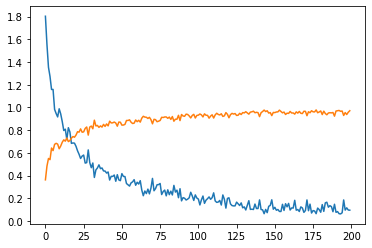

NameError: name 'tqdm' is not defined

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_path = 'SCAN-master'
task_name = 'simple'  # or 'length'

train_file_name = '{}_split/tasks_{}_{}.txt'.format(task_name, 'train', task_name)
test_file_name = '{}_split/tasks_{}_{}.txt'.format(task_name, 'test', task_name)
train_file_path = os.path.join(dataset_path, train_file_name)
test_file_path = os.path.join(dataset_path, test_file_name)
# train_file_path, test_file_path

SOS_token = 0
EOS_token = 1

command_le = Lang('command')
action_le = Lang('action')


def dataloader(path):
    with open(path, 'r') as f:
        dataset = f.readlines()

    def preprocess_data(line):
        line = line.strip().split()
        split_index = line.index('OUT:')
        inp = line[1: split_index]
        outp = line[split_index + 1:]
        command_le.addSentence(inp)
        action_le.addSentence(outp)
        return [inp, outp]

    pairs = list(map(preprocess_data, dataset))
    input_commands, output_actions = np.transpose(pairs).tolist()
    return input_commands, output_actions, pairs


commands_train, actions_train, pairs_train = dataloader(train_file_path)
commands_test, actions_test, pairs_test = dataloader(test_file_path)

MAX_LENGTH = max([len(action) for action in actions_train]) + 1

teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder,
          encoder_optimizer, decoder_optimizer, criterion
          ):
    encoder_hidden = encoder.initHidden()
    encoder_cell = encoder.initCell()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0
    gold_pred = 0

    for ei in range(input_length):
        encoder_output, (encoder_hidden, encoder_cell) = encoder(
            input_tensor[ei], (encoder_hidden, encoder_cell))

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        for di in range(target_length):
            decoder_output, (decoder_hidden, decoder_cell) = decoder(
                decoder_input, (decoder_hidden, decoder_cell))
            topv, topi = decoder_output.topk(1)
            pred = topi.squeeze()

            if torch.equal(pred, target_tensor[di].squeeze()):
                gold_pred += 1

            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]


    else:
        for di in range(target_length):
            decoder_output, (decoder_hidden, decoder_cell) = decoder(
                decoder_input, (decoder_hidden, decoder_cell))
            topv, topi = decoder_output.topk(1)
            pred = topi.squeeze()
            decoder_input = topi.squeeze().detach()

            if torch.equal(pred, target_tensor[di].squeeze()):
                gold_pred += 1

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                target_length = di + 1
                break

    loss.backward()

    torch.nn.utils.clip_grad_value_(encoder.parameters(), 5.0)
    torch.nn.utils.clip_grad_value_(decoder.parameters(), 5.0)
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length, gold_pred, target_length


def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100,
               learning_rate=0.001):
    start = time.time()

    plot_losses = []
    plot_accs = []
    print_loss_total = 0
    plot_loss_total = 0
    print_pred_total = 0
    print_label_total = 0
    plot_pred_total = 0
    plot_label_total = 0

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs_train), command_le, action_le)
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        # target_length = target_tensor.size(0)

        loss, gold_pred, target_length = train(input_tensor, target_tensor, encoder,
                                               decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_label_total += target_length
        print_pred_total += gold_pred
        plot_label_total += target_length
        plot_pred_total += gold_pred
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_acc_avg = print_pred_total / print_label_total
            print_loss_avg = print_loss_total / print_every
            print_pred_total = 0
            print_label_total = 0
            print_loss_total = 0
            print('%s (%d %d%%) loss: %.4f acc: %.4f' % (timeSince(start, iter / n_iters),
                                                         iter, iter / n_iters * 100, print_loss_avg, print_acc_avg))

        if iter % plot_every == 0:
            plot_acc_avg = plot_pred_total / plot_label_total
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_accs.append(plot_acc_avg)
            plot_loss_total = 0
            plot_pred_total = 0
            plot_label_total = 0

    showPlot(plot_losses, plot_accs)


def evaluate(encoder, decoder, pair, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor, target_tensor = tensorsFromPair(pair, command_le, action_le)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_cell = encoder.initCell()

        for ei in range(input_length):
            encoder_output, (encoder_hidden, encoder_cell) = encoder(input_tensor[ei],
                                                                     (encoder_hidden, encoder_cell))

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        decoded_words = []

        for di in range(max_length):
            decoder_output, (decoder_hidden, decoder_cell) = decoder(
                decoder_input, (decoder_hidden, decoder_cell))
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(action_le.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words


def evaluate_model(encoder, decoder, test_pairs):
    gold = 0
    total_target = 0
    for pair in tqdm(test_pairs):
        preds = evaluate(encoder, decoder, pair)[:-1]
        target_output = pair[1]
        length = min(len(preds), len(target_output))
        target_length = len(target_output)
        # total_target += length
        total_target += target_length

        for i in range(length):
            if preds[i] == target_output[i]:
                gold += 1
    return gold / total_target


if __name__ == '__main__':
    hidden_size = 200
    num_iter = 100000
    input_size = command_le.n_words
    output_size = action_le.n_words
    encoder = EncoderLSTM(input_size, hidden_size, num_layers=2, dropout=0).to(device)
    decoder = DecoderLSTM(hidden_size, output_size, num_layers=2, dropout=0).to(device)

    trainIters(encoder, decoder, num_iter, print_every=1000)
    evaluate_model(encoder, decoder, pairs_test)


In [5]:
evaluate_model(encoder, decoder, pairs_test)

100%|███████████████████████████████████████████████████████████████████████████| 17565/17565 [02:35<00:00, 113.28it/s]


0.9683943797485153

In [6]:
def evaluate_model(encoder, decoder, test_pairs):
    gold = 0
    total_target = 0
    for pair in tqdm(test_pairs):
        preds = evaluate(encoder, decoder, pair)[:-1]
        target_output = pair[1]
        length = min(len(preds), len(target_output))
        target_length = len(target_output)
        total_target += target_length
        
        for i in range(length):
            if preds[i] == target_output[i]:
                gold += 1
    return gold / total_target
evaluate_model(encoder, decoder, pairs_test)

100%|███████████████████████████████████████████████████████████████████████████| 17565/17565 [02:21<00:00, 123.93it/s]


0.928195221229792